# Imports

In [22]:
import pandas as pd
import math
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

# Inladen opgeschoonde dataset

In [23]:
disruptions = pd.read_csv("clean.csv")
disruptions = disruptions.convert_dtypes()
disruptions.head()

,stm_prioriteit,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur
0,9,00:00:00,99999999.0,09:00:00,0
1,9,00:00:00,99999999.0,12:35:00,51
2,9,00:00:00,99999999.0,16:40:00,40
3,9,00:00:00,99999999.0,22:30:00,6
4,9,00:00:00,99999999.0,11:23:00,7


# Data cleanup

Hieronder worden de lege values opgevuld met prioriteit 9, dit omdat er ten eerste maar 112 values leeg zijn, en ten tweede omdat wij er vanuit gaan dat als de prioriteit niet is ingevuld, het geen belangrijk probleem is geweest.

In [24]:
disruptions['stm_prioriteit'] = disruptions['stm_prioriteit'].fillna(9)
disruptions['stm_prioriteit'] = disruptions['stm_prioriteit'].astype(str)
disruptions['stm_prioriteit'] = 'prio: ' + disruptions['stm_prioriteit'] 
dummies = pd.get_dummies(disruptions['stm_prioriteit'])
disruptions = disruptions.drop('stm_prioriteit', axis = 1)
disruptions = disruptions.join(dummies)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
0,00:00:00,99999999.0,09:00:00,0,0,0,0,0,0,1
1,00:00:00,99999999.0,12:35:00,51,0,0,0,0,0,1
2,00:00:00,99999999.0,16:40:00,40,0,0,0,0,0,1
3,00:00:00,99999999.0,22:30:00,6,0,0,0,0,0,1
4,00:00:00,99999999.0,11:23:00,7,0,0,0,0,0,1


Hieronder word stm_fh_duur opgeschoond. Allereerst verwijderen we alles waarbij de duur 0 is, omdat we niet geïnteresseerd zijn in dit voorspellen, omdat de dienstregeling hierdoor niet verstoord wordt. Darnaast verwijderen we ook alle sterke outliers, zodat de data minder ruis bevat.

In [25]:
disruptions = disruptions[disruptions.stm_fh_duur != 0]
# Omdat we alleen geïnteresseerd zijn in de storingen korter dan 1 dag, worden outliers automatisch verwijderd.
disruptions = disruptions[disruptions.stm_fh_duur < 1440]
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,00:00:00,99999999.0,12:35:00,51,0,0,0,0,0,1
2,00:00:00,99999999.0,16:40:00,40,0,0,0,0,0,1
3,00:00:00,99999999.0,22:30:00,6,0,0,0,0,0,1
4,00:00:00,99999999.0,11:23:00,7,0,0,0,0,0,1
5,00:00:00,99999999.0,23:25:00,13,0,0,0,0,0,1


Hieronder worden alle tijden en data omgezet naar pure getallen, zodat het model hiermee kan werken.

In [26]:
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_sap_meldtijd != '']
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].dropna()
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].astype(int)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,00:00:00,99999999.0,123500,51,0,0,0,0,0,1
2,00:00:00,99999999.0,164000,40,0,0,0,0,0,1
3,00:00:00,99999999.0,223000,6,0,0,0,0,0,1
4,00:00:00,99999999.0,112300,7,0,0,0,0,0,1
5,00:00:00,99999999.0,232500,13,0,0,0,0,0,1


In [27]:
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_aanntpl_tijd != '']
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].dropna()
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].astype(int)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,0,99999999.0,123500,51,0,0,0,0,0,1
2,0,99999999.0,164000,40,0,0,0,0,0,1
3,0,99999999.0,223000,6,0,0,0,0,0,1
4,0,99999999.0,112300,7,0,0,0,0,0,1
5,0,99999999.0,232500,13,0,0,0,0,0,1


Ten slotte moeten de prognoses van de monteurs worden opgeschoond, zodat er een eerlijke vergelijking kan worden gemaakt tussen hun voorspellingen en die van het model.

In [28]:
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: not x.startswith("-"))]
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: not x.endswith("-"))]
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: x.isnumeric())]
disruptions['stm_progfh_in_duur'] = disruptions['stm_progfh_in_duur'].astype(int)
disruptions = disruptions[disruptions.stm_progfh_in_duur < 1440]
disruptions = disruptions[disruptions.stm_progfh_in_duur > 0]
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
32028,50500,40,205000,43,0,0,0,0,0,1
60974,53641,293,141200,236,0,0,0,0,0,1
62340,3000,270,90537,1012,0,1,0,0,0,0
62500,104600,29,121627,1065,0,0,0,0,0,1
63458,10000,180,101131,593,0,0,0,0,0,1


# Baseline

De baseline is een simpel model dat constant het gemiddelde voorspelt, deze wordt gebruikt om in de beginfases van het model te testen.

In [29]:
disruptions['baseline'] = disruptions['stm_fh_duur']
gem =  sum(disruptions['baseline'])/ len(disruptions['baseline'])
disruptions['baseline'] = disruptions['baseline'].apply(lambda x : gem)
disruptions['baseline'] = disruptions['baseline'].astype(int)
np.sqrt(mean_squared_error(disruptions['stm_fh_duur'], disruptions['baseline']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


325.5889797221691

# Voorspellingen van de monteurs

<AxesSubplot:xlabel='stm_progfh_in_duur', ylabel='stm_fh_duur'>

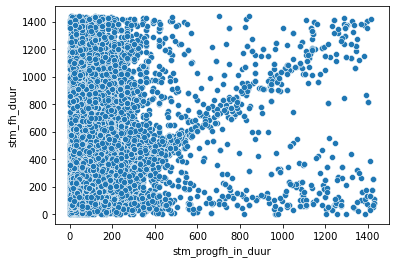

In [30]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_progfh_in_duur'])

In [31]:
print(f"RSME: {np.sqrt(mean_squared_error(disruptions['stm_fh_duur'], disruptions['stm_progfh_in_duur']))}")

RSME: 361.74595755207895


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


# Model

## De variabelen voorbereiden

Allereerst moeten de x en de y worden bepaald.

In [32]:
x = disruptions[['stm_sap_meldtijd', 'stm_aanntpl_tijd']]
y = disruptions['stm_fh_duur'].astype('int')

Daarna worden deze opgesplitst in een train en een test set.

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

Nu we onze data goed hebben voorbereid, kunnen er modellen mee getraind worden. 
Allereerst trainen we een DecisionTreeClassifier, en bepalen we de score.

## Decision tree classifier

In [34]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
acc = dtc.score(X_test, Y_test)
y_pred = dtc.predict(X_test)
print("Acc: " + str(acc))
pred = dtc.predict([[171514, 180001]])
print(pred)

Acc: 0.32136727688787187
[68]


In [75]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
acc = rf.score(X_test, Y_test)
np.sqrt(mean_squared_error(Y_test, y_pred))
print("Acc: " + str(acc))

KeyboardInterrupt: 

Hieronder staat het script dat de beste waarde voor de max depth opzoekt. We zijn hier geintereseerd in de waarde waar de curve afvlakt.

In [43]:
depths = []
scores = []

for depth in range(1, 80):
    dtc = DecisionTreeClassifier(max_depth= depth)
    dtc.fit(X_train, Y_train)
    y_pred = dtc.predict(X_test)    
    depths.append(depth)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(depths, scores, color="g")
plt.xlabel("Depth")
plt.ylabel("Score")
plt.show()

KeyboardInterrupt: 

Hieronder tonen we de boom, zodat we (visueel) kunnen zien of de boom niet overfit is.

In [129]:
plt.figure(figsize=(15,11), dpi=100)

tree.plot_tree(dtc, rounded=True, filled=True)

plt.show()

KeyboardInterrupt: 

## K nearest neighbours model

Nu trainen we ook een KNN model. Dit doen we ten eerste om te kijken welk model beter scoort, maar ook als een controle of ons eerste model niet overfit is.

In [35]:
knc = KNeighborsClassifier(n_neighbors = 53)
knc.fit(X_train, Y_train)
knc.set_params(weights="distance")
acc = knc.score(X_test, Y_test)
print("Model Accuracy: " + str(acc))
y_pred = knc.predict(X_test)
prediction = knc.predict([[171514, 180001], [133755, 144000] , [171022, 172656]])

print(prediction)
np.sqrt(mean_squared_error(Y_test, y_pred))

Model Accuracy: 0.323512585812357
[113 122  38]


155.12344220863093

Hieronder staat het script dat berekent welke N waarde het beste scoort. Omdat N niet te laag mag zijn wegens risico op overfitting moet worden gekeken naar waar de grafiek het meeste afvlakt en niet naar de eerste piek.

In [44]:
neighbours = []
scores = []
knc = KNeighborsClassifier()
knc.fit(X_train, Y_train)
for neighbour in range(1, 80):
    knc.set_params(n_neighbors = neighbour, weights="distance")
    y_pred = knc.predict(X_test)    
    neighbours.append(neighbour)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(neighbours, scores, color="g")
plt.xlabel("Neighbours")
plt.ylabel("Score")
plt.show()

KeyboardInterrupt: 

## Lineare regressie

Voordat er een lineare regressie model kan worden gemaakt, moet er eerst worden gekeken naar de correlaties met de target variabele, stm_fh_duur. We zijn geïnteresseerd in de hoogste correlaties. (zowel negatief als positief)

In [36]:
all_columns = disruptions.columns.values
disruptions[all_columns].corr()['stm_fh_duur'].sort_values()

prio: 2              -0.375567
stm_aanntpl_tijd     -0.271526
prio: 9              -0.035709
prio: 8               0.009560
prio: 1               0.015186
stm_sap_meldtijd      0.082614
prio: 4               0.175678
prio: 5               0.252008
stm_progfh_in_duur    0.295188
stm_fh_duur           1.000000
baseline                   NaN
Name: stm_fh_duur, dtype: float64

In [37]:
X=disruptions[['prio: 1', 'prio: 2' , 'prio: 4', 'prio: 5', 'stm_sap_meldtijd', 'stm_aanntpl_tijd', 'stm_progfh_in_duur']]
Y=disruptions['stm_fh_duur'].astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [38]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_test)
acc = lr.score(X_test, Y_test)
print("Model Accuracy: " + str(acc))
np.sqrt(mean_squared_error(Y_test, y_pred))
lr.predict([[0,1,0,0,171514,180001,30],[0,1,0,0,133755,144000,77],[1,0,0,0,171022,172656,170]])

Model Accuracy: 0.32873220377930457


array([ 44.48354955,  86.88569738, 260.15595253])

Naast een normale lineare lijn kunnen we ook een polynoom plotten om te kijken of deze beter scoort.

In [40]:
pf = PolynomialFeatures()
pf_ft = pf.fit_transform(X_test)
pf.fit(pf_ft,Y_test)
lr = LinearRegression()
lr.fit(pf_ft,Y_test)
acc = lr.score(pf_ft, Y_test)
print("acc: ",acc)
y_pred = lr.predict(pf.fit_transform(X_test))
np.sqrt(mean_squared_error(Y_test, y_pred))
print(math.trunc(lr.predict(pf.fit_transform(np.array([0,1,0,0,171514,180001,30]).reshape(1,-1)))[0]))
print(math.trunc(lr.predict(pf.fit_transform(np.array([0,1,0,0,133755,144000,77]).reshape(1,-1)))[0]))
print(math.trunc(lr.predict(pf.fit_transform(np.array([1,0,0,0,171022,172656,170]).reshape(1,-1)))[0]))

acc:  0.3737276273641602
64
115
227


In [42]:
degrees = []
scores = []
for degree in range(1, 10):
    pf=PolynomialFeatures(degree = degree)
    pf_ft=pf.fit_transform(X_test)
    pf.fit(pf_ft,Y_test)
    lin_reg=LinearRegression()
    lin_reg.fit(pf_ft,Y_test) 
    degrees.append(degree)
    scores.append(lin_reg.score(pf_ft, Y_test))   
plt.figure(figsize=(15,11), dpi=50)
plt.plot(degrees, scores, color="g")
plt.xlabel("Degrees")
plt.ylabel("Score")

KeyboardInterrupt: 

# Grafieken

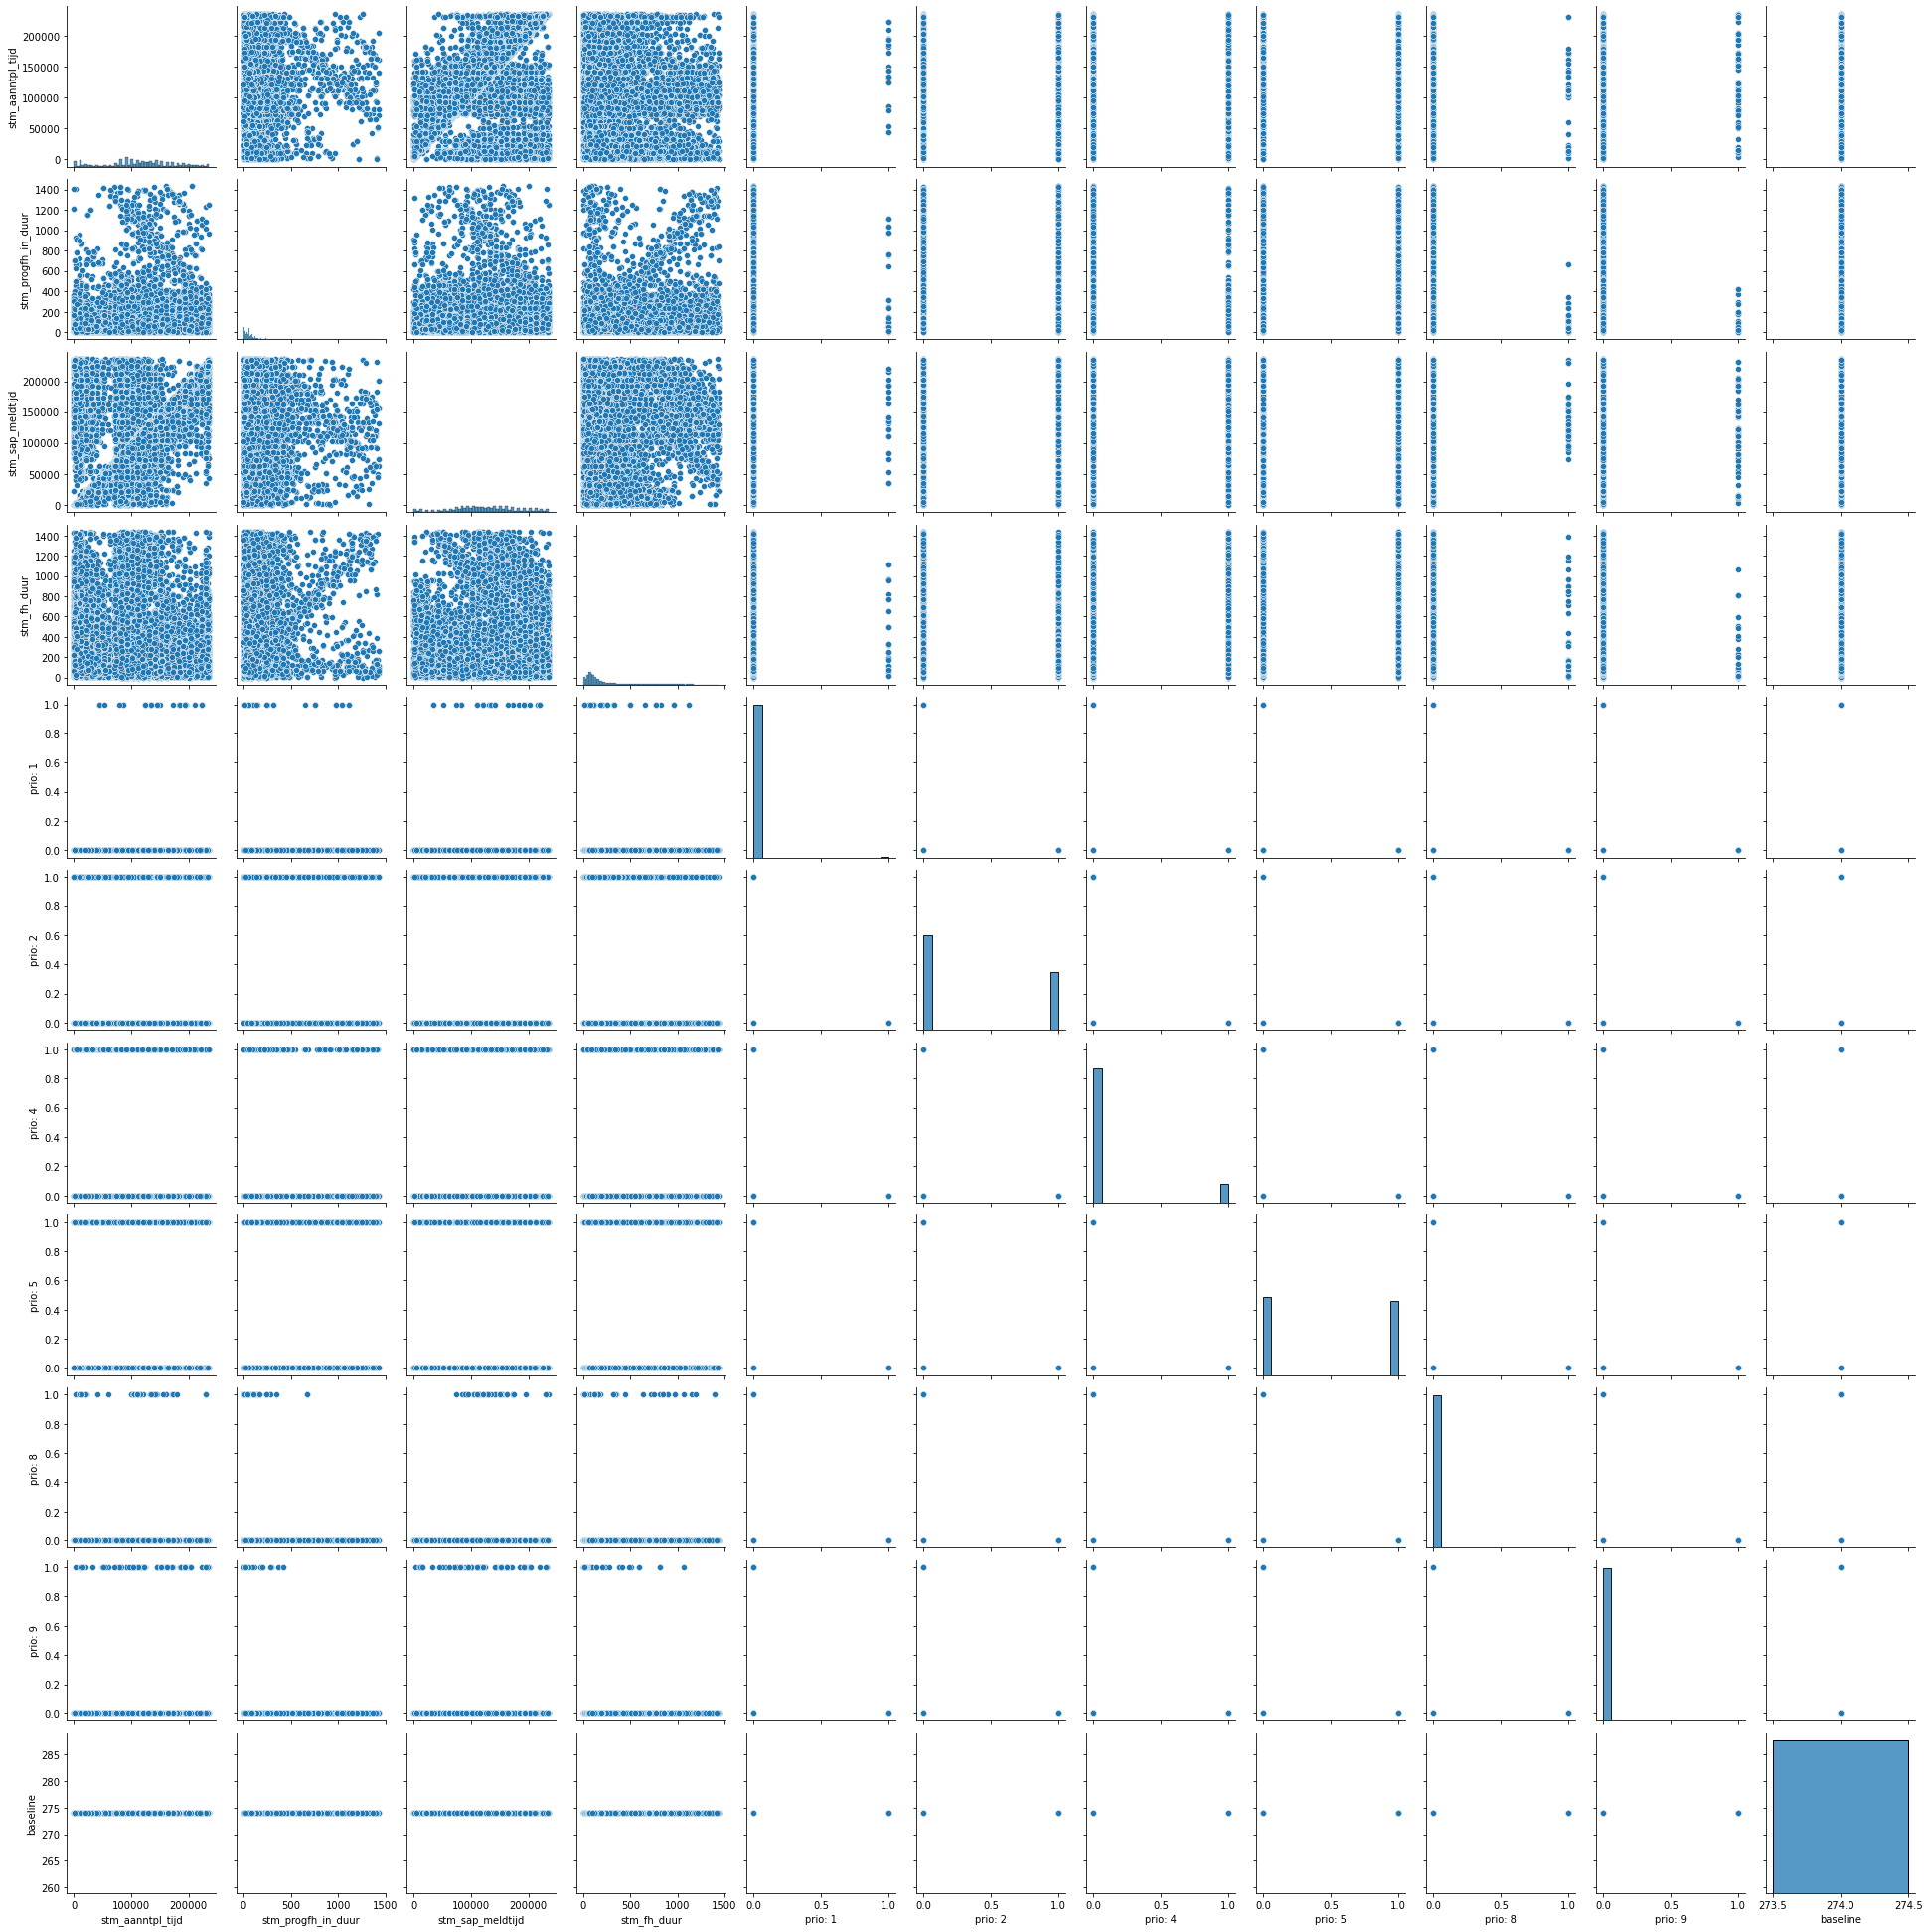

In [21]:
sb.pairplot(disruptions)

<AxesSubplot:xlabel='stm_sap_meldtijd', ylabel='Count'>

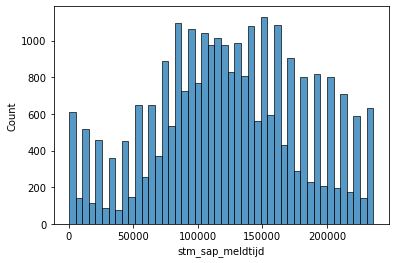

In [22]:
sb.histplot(disruptions['stm_sap_meldtijd'])

<AxesSubplot:xlabel='stm_aanntpl_tijd', ylabel='Count'>

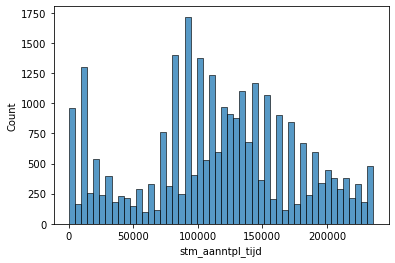

In [23]:
sb.histplot(disruptions['stm_aanntpl_tijd'])

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Count'>

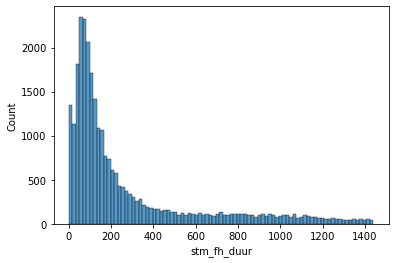

In [24]:
sb.histplot(disruptions['stm_fh_duur'])

<AxesSubplot:xlabel='stm_sap_meldtijd', ylabel='Count'>

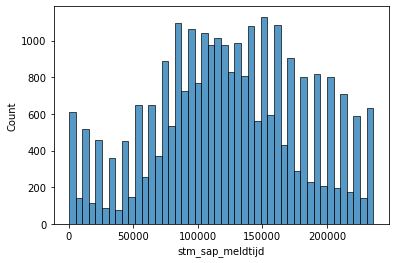

In [25]:
sb.histplot(disruptions['stm_sap_meldtijd'])

<AxesSubplot:xlabel='stm_sap_meldtijd', ylabel='stm_fh_duur'>

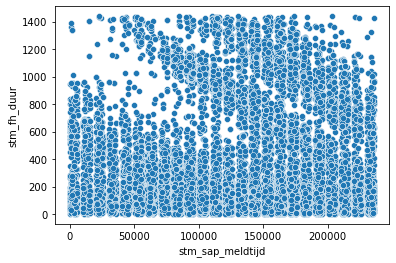

In [26]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_sap_meldtijd'])

<AxesSubplot:xlabel='stm_aanntpl_tijd', ylabel='Count'>

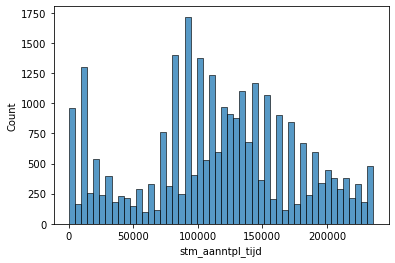

In [27]:
sb.histplot(disruptions['stm_aanntpl_tijd'])

<AxesSubplot:xlabel='stm_aanntpl_tijd', ylabel='stm_fh_duur'>

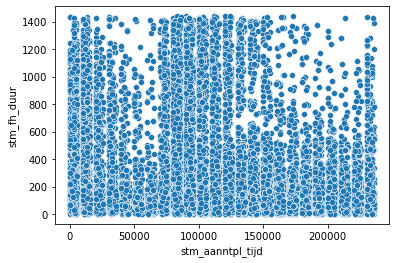

In [28]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_aanntpl_tijd'])

# Bijlage 

Hier staan code snippets e.d. die gebruikt zijn, maar uiteindelijk niet nodig waren voor het model.

In [29]:
disruptions.describe() #delete me in final version

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9,baseline
count,27967.000000,27967.000000,27967.000000,27967.00000,27967.000000,27967.000000,27967.000000,27967.000000,27967.000000,27967.000000,27967.0
mean,115432.763042,100.166267,123867.244574,274.02317,0.001180,0.381664,0.122895,0.488862,0.001824,0.003576,274.0
std,59720.738176,158.264594,56992.233032,325.59480,0.034331,0.485804,0.328322,0.499885,0.042665,0.059691,0.0
min,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,274.0
25%,82000.000000,25.000000,84647.000000,70.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,274.0
50%,115532.000000,58.000000,123200.000000,131.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,274.0
75%,154500.000000,110.000000,163845.500000,321.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,274.0
max,235926.000000,1430.000000,235959.000000,1439.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,274.0


In [30]:
print(disruptions.isnull().sum().to_string())

stm_aanntpl_tijd      0
stm_progfh_in_duur    0
stm_sap_meldtijd      0
stm_fh_duur           0
prio: 1               0
prio: 2               0
prio: 4               0
prio: 5               0
prio: 8               0
prio: 9               0
baseline              0


In [31]:
disruptions.dtypes

stm_aanntpl_tijd      int32
stm_progfh_in_duur    int32
stm_sap_meldtijd      int32
stm_fh_duur           Int64
prio: 1               uint8
prio: 2               uint8
prio: 4               uint8
prio: 5               uint8
prio: 8               uint8
prio: 9               uint8
baseline              int32
dtype: object

In [32]:
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9,baseline
32028,50500,40,205000,43,0,0,0,0,0,1,274
60974,53641,293,141200,236,0,0,0,0,0,1,274
62340,3000,270,90537,1012,0,1,0,0,0,0,274
62500,104600,29,121627,1065,0,0,0,0,0,1,274
63458,10000,180,101131,593,0,0,0,0,0,1,274


# Inladen volledige dataset

Allereerst moet de gehele dataset worden ingeladen.

In [40]:
data = pd.read_csv("sap_storing_data_hu_project.csv")
disruptions = pd.DataFrame(data=data, index=data.index, columns=['stm_oorz_groep', 'stm_oorz_code','stm_geo_gst', 'stm_fh_ddt',
                                                               'stm_sap_storeind_ddt', 'stm_sap_melddatum', 'stm_sap_meldtijd',
                                                               'stm_aanntpl_tijd', 'stm_fh_dd', 'stm_fh_tijd', 'stm_fh_duur',
                                                               'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                                                               'stm_prioriteit', 'stm_progfh_in_duur'])
disruptions = disruptions.drop_duplicates()
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,0,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,NaN,624.0,624.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS MAFD,NaN,NaN,00/00/0000,02/01/2006 09:00:00,NaN,81S,624.0,624.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-RIB,133.0,Papieren ontbreken,ONREGRIB,B,Volker,NaN,NaN,02/01/2006 09:00:00,4.0,02/01/2006 09:00:00,NaN,NaN,N,NaN,NaN,0,B,"0,00",NaN,03/01/2006,04:48:18,02/01/2006,09:00:00,NaN,NaN,NaN,624,NaN,81.0,624,S,02/01/2006,09:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,09:00:00,0.0,99999999.0,02/01/2006,09:00:00,NaN,NaN,05/01/2006,J,NaN,N,J,05/01/2009 15:10:09,05/01/2009,15:10:09,02/01/2006 04:

# Verwijderen van de n.v.t. kolommen

De opdrachtgever heeft aangegeven dat een aantal kolommen n.v.t. zijn, daarnaast zijn er nog meer kolommen die niet van toepassing zijn, zoals bijvoorbeeld database modifiers en de tijd dat de storing is opgelost. Deze laatste is niet van toepassign omdat je deze niet van te voren in kan voeren. De overgebleven kolommen worden in de dataset geladen. Daarnaast worden ook de duplicaten verwijderd, de eerste lege regel verwijderd, en de datatypes omgezet tot het best passende formaat.

In [41]:
disruptions = pd.DataFrame(data=disruptions, index=disruptions.index, columns=['stm_prioriteit', 'stm_aanntpl_tijd', 'stm_progfh_in_duur',
                                                               'stm_sap_meldtijd', 'stm_fh_duur'])
disruptions = disruptions.iloc[1: , :]
disruptions = disruptions.convert_dtypes()
disruptions.head()
#print(len(storingen))

,stm_prioriteit,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur
1,9,00:00:00,99999999.0,09:00:00,0
2,9,00:00:00,99999999.0,12:35:00,51
3,9,00:00:00,99999999.0,16:40:00,40
4,9,00:00:00,99999999.0,22:30:00,6
5,9,00:00:00,99999999.0,11:23:00,7


In [42]:
disruptions.to_csv(path_or_buf='clean.csv', index=False)

# Data cleanup - unused

Hieronder wordt een nieuwe code aangemaakt voor onbekende stm_ooz_codes, 0.

In [76]:
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].astype(str)
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].str.replace('<NA>', '0')
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].fillna('0')
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].astype(int)

Hieronder worden alle stm_geo_gst die niet numeriek zijn, verwijderd, zodat deze hele kolom kan worden omgezet tot een int. Hierdoor kan het model hiermee kan werken.

In [78]:
disruptions =  disruptions[disruptions.stm_geo_gst.astype(str).apply(lambda x: x.isnumeric())]
disruptions["stm_geo_gst"] = disruptions["stm_geo_gst"].astype(int)

In [79]:
disruptions["stm_sap_melddatum"] = pd.to_datetime(disruptions["stm_sap_melddatum"])
disruptions["stm_sap_melddatum"] = disruptions["stm_sap_melddatum"].dropna().apply(lambda a: int(a.strftime('%Y%m%d')))
disruptions["stm_sap_melddatum"] = disruptions["stm_sap_melddatum"].astype(int)

In [81]:
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].str.replace("/", "")
disruptions = disruptions[disruptions.stm_aanntpl_dd != '']
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].dropna()
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].astype(int)

In [83]:
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].str.replace("/", "")
disruptions = disruptions[disruptions.stm_aanngeb_dd != '']
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].dropna()
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].astype(int)

In [84]:
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_aanngeb_tijd != '']
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].dropna()
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].astype(int)

Hieronder worden dummies aangemaakt voor stm_oporzaak_groep.

In [85]:
dummies = pd.get_dummies(disruptions['stm_oorz_groep'])
disruptions = disruptions.drop('stm_oorz_groep',axis = 1)
disruptions = disruptions.join(dummies)

In [35]:
disruptions['stm_sap_meldtijd'] = disruptions['stm_sap_meldtijd'].str.replace("::", "00:00:00")
disruptions['stm_sap_meld_ddt'] = pd.to_datetime(disruptions.stm_sap_melddatum[disruptions.stm_sap_melddatum != '00000000'].dropna().astype(str) + ' ' + disruptions.stm_sap_meldtijd[disruptions.stm_sap_meldtijd != '00:00:00'].dropna().astype(str))

,stm_oorz_code,stm_geo_gst,stm_fh_ddt,stm_sap_storeind_ddt,stm_sap_melddatum,stm_sap_meldtijd,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_progfh_in_duur,prioriteit: 1,prioriteit: 2,prioriteit: 4,prioriteit: 5,prioriteit: 8,prioriteit: 9,ONR-DERD,ONR-RIB,TECHONV,WEER
542417,227,516,04/12/2015 11:37:00,<NA>,20150412,95919,4122015,95919,4122015,110000,04/12/2015,11:37:00,98,<NA>,00:00:00,60,0,0,0,1,0,0,0,0,1,0
542418,227,516,04/12/2015 11:37:00,23/03/2016 16:00:00,20150412,95919,4122015,95919,4122015,110000,04/12/2015,11:37:00,98,23/03/2016,16:00:00,60,0,0,0,1,0,0,0,0,1,0
542419,228,118,04/12/2015 12:35:00,04/12/2015 12:35:00,20150412,100042,4122015,100042,4122015,104100,04/12/2015,12:35:00,154,04/12/2015,12:35:00,114,0,1,0,0,0,0,0,0,1,0
542420,143,105,04/12/2015 13:15:00,08/12/2015 10:34:00,20150412,100529,4122015,100529,4122015,101100,04/12/2015,13:15:00,190,08/12/2015,10:34:00,184,0,0,0,1,0,0,1,0,0,0
542431,215,620,04/12/2015 15:25:00,07/12/2015 11:02:00,20150412,105712,4122015,105712,4122015,143300,04/12/2015,15:25:00,268,07/12/2015,11:02:00,52,0,0,0,1,0,0,0,0,1,0


In [32]:
sb.histplot(disruptions['stm_prioriteit'])

KeyError: 'stm_prioriteit'

In [ ]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_prioriteit'])

In [33]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_oorz_groep'])

KeyError: 'stm_oorz_groep'

In [34]:
sb.histplot(disruptions['stm_oorz_code'])

KeyError: 'stm_oorz_code'

In [35]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_oorz_code'])

KeyError: 'stm_oorz_code'

In [38]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_sap_melddatum'])

KeyError: 'stm_sap_melddatum'

In [41]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_geo_gst'].astype(str))

KeyError: 'stm_geo_gst'

In [42]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_sap_melddatum'])

KeyError: 'stm_sap_melddatum'